In [198]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.gridspec as gridspec

Parámetros del sistema

In [199]:
w_0 = 1 # Frecuencia natural x>0
W_0 = 5 # Frecuencia natural x<0
amort = 0 # constante de amortiguamiento
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa
m = 1 # masa del oscilador
N = 150 # Numero de fonones
w = [1,1.2] # frecuencia de la fuerza externa
X_0 = 3 # Condición inicial
n = np.size(w)

In [200]:
rep = n-2 # w para la que queremos las figuras

Frecuencia natural del oscilador

In [201]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [202]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [203]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/(np.pi))**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [204]:
x = np.linspace(-10,10,500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

100%|██████████| 150/150 [01:29<00:00,  1.68it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


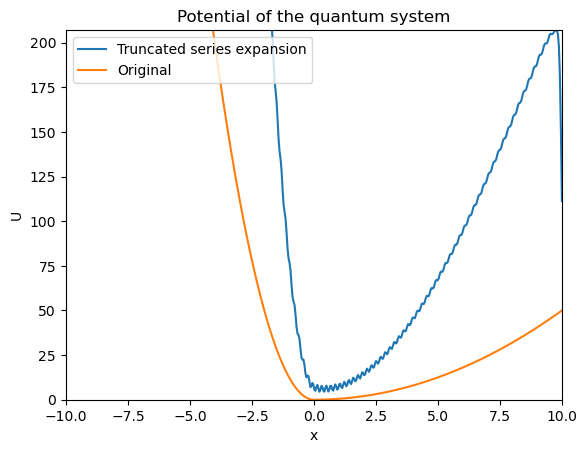

In [205]:
fig1 = plt.figure()
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()
plt.show()

Simulación de la dinámica cuántica

In [206]:
dt = 0.05 # Paso de tiempo
tf = 50 # Tiempo de medida (se asume que t0 = 0)
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

In [207]:
lines = ['dt = '+str(dt),'tf = '+str(tf),'w_0 = '+str(w_0),'W_0 = '+str(W_0),'f_0 = '+str(f_0),'N = '+str(N),'X_0 = '+str(X_0),'w = '+str(w)]
with open('param.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [208]:
def check_state(psi):
    check = np.sum(np.diagonal(ket2dm(psi).full())[-5:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [209]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m) 
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

# Estado para comparar:
# psi02 = coherent(N,math.sqrt(0.6))

In [210]:
def H1coeff(t,args):
    return f_0*m*np.cos(args['w']*t)

In [211]:
result = []
H0 = w_0*momentum(N)**2/2+U_q
H1 = position(N)/math.sqrt(w_0*m)
options = Options(store_states=True,nsteps=5000)
for i in range(n):
    args = {'w': w[i]}
    H = [H0,[H1,H1coeff]]
    result.append(mesolve(H, psi0, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options,args=args))
    # result2 = mesolve(H, psi02, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options)

Overlap integrals

In [212]:
O = []
coh = []

for j in range(n):
    aux = []
    aux2 = []
    for i in tqdm(range(np.size(tvec))): 
        psi = result[j].states[i]
        check_state(psi)
        alpha = expect(destroy(N),psi)
        
        psi_t = coherent(N,alpha)
        aux.append(psi.overlap(psi0))
        aux2.append(psi_t.overlap(psi))
    O.append(aux)
    coh.append(aux2)

100%|██████████| 1001/1001 [00:16<00:00, 61.32it/s]


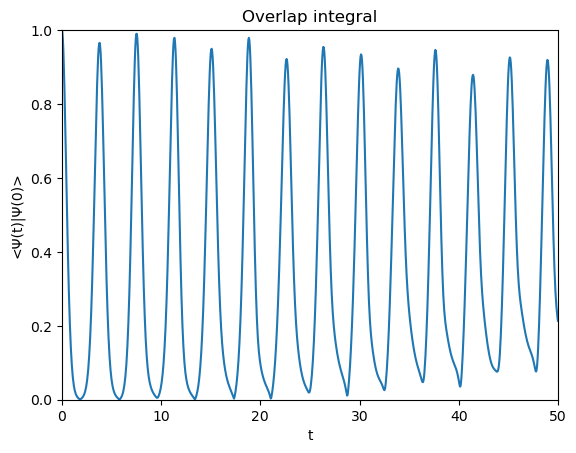

In [213]:
fig2 = plt.figure()
plt.plot(tvec,np.abs(O[rep]))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Overlap integral')
plt.xlabel('t')
plt.ylabel('<Ψ(t)|Ψ(0)>')
plt.show()

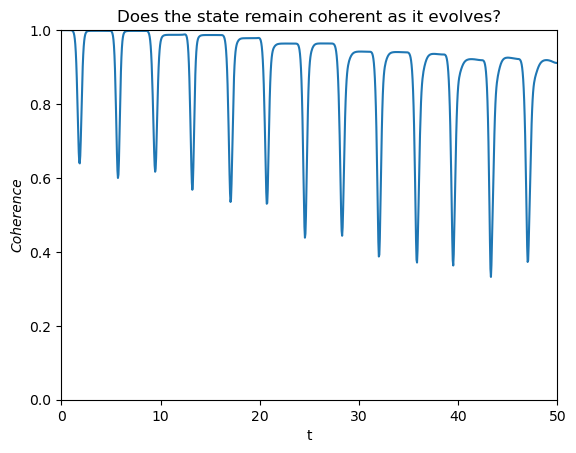

In [214]:
fig3 = plt.figure()
plt.plot(tvec,np.abs(coh[rep]))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Does the state remain coherent as it evolves?')
plt.xlabel('t')
plt.ylabel('Coherence', style = 'italic')
plt.show()

In [215]:
fou = scipy.fft.fft(np.abs(O))
nO = np.size(np.abs(O[0]))
freq = np.fft.fftfreq(nO, 0.1)[:nO//2]

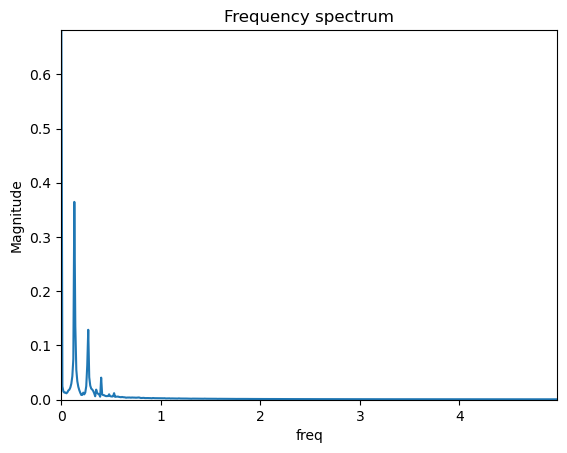

In [216]:
fig4 = plt.figure()
plt.plot(freq,(2/nO)*np.abs(fou[rep][:nO//2]))
plt.xlim([np.min(freq),np.max(freq)])
plt.ylim([0,max((2/nO)*fou[rep])])
plt.title('Frequency spectrum')
plt.xlabel('freq')
plt.ylabel('Magnitude')
plt.show()

In [217]:
desv_x = []
desv_p = []

for i in range(n):
    desv_x.append(np.sqrt(result[i].expect[2]-result[i].expect[0]*result[i].expect[0]))
    desv_p.append(np.sqrt(result[i].expect[3]-result[i].expect[1]*result[i].expect[1]))

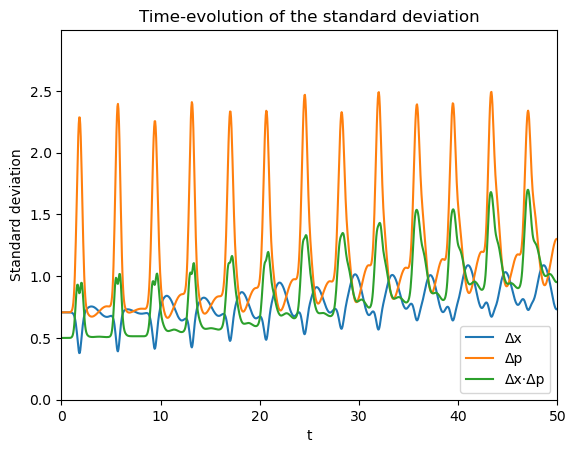

In [218]:
fig5 = plt.figure()
plt.plot(tvec,desv_x[rep], label = 'Δx')
plt.plot(tvec,desv_p[rep], label = 'Δp')
plt.plot(tvec,desv_x[rep]*desv_p[rep], label = 'Δx·Δp')
plt.ylim([0,np.max(desv_p[rep])+0.5])
plt.xlim([0,tf])
plt.title('Time-evolution of the standard deviation')
plt.xlabel('t')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()

Comparación con caso clásico

In [219]:
def EDO(t,y,w):
    x,v = y
    return [v,-2*amort*v-W(x)**2*x+f_0*np.cos(w*t)]

In [220]:
pos = []
mom = []

for i in tqdm(range(np.size(w))):
    sol = scipy.integrate.solve_ivp(EDO, [0,tf], [x_0,p_0], method = 'DOP853',t_eval = tvec,args = [w[i]])
    xc,vc = sol.y
    pos.append(xc)
    mom.append(vc*m)

100%|██████████| 2/2 [00:00<00:00, 14.78it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


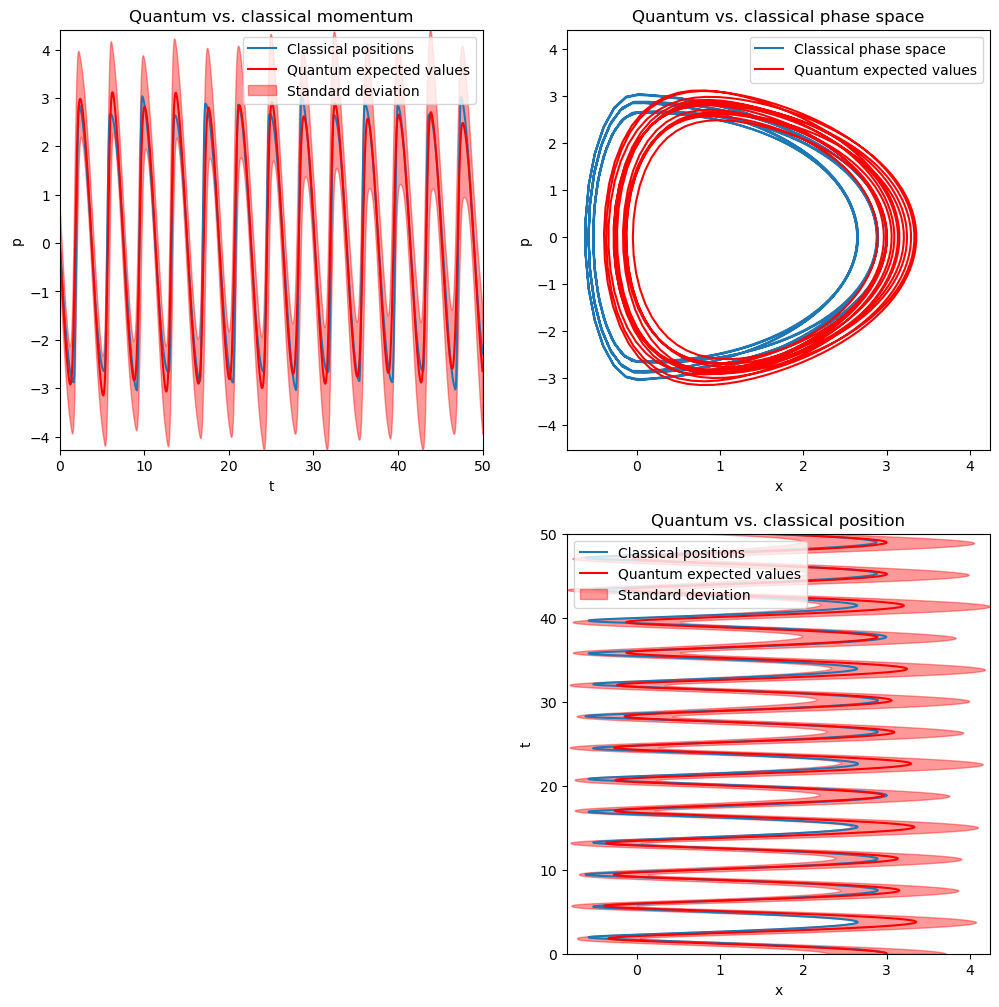

In [221]:
fig6 = plt.figure(figsize=(12,12), constrained_layout=True)

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax3 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])
ax2 = plt.subplot(gs[1, 2:])

ax1.plot(pos[rep],mom[rep],label='Classical phase space')
ax1.plot(result[rep].expect[0],result[rep].expect[1],label='Quantum expected values',color = 'red')
ax1.set_ylim([np.min(result[rep].expect[1]-desv_p),np.max(result[rep].expect[1]+desv_p)])
ax1.set_xlim([np.min(result[rep].expect[0]-desv_x[rep]),np.max(result[rep].expect[0]+desv_x[rep])])
ax1.set_title('Quantum vs. classical phase space')
ax1.set_xlabel('x')
ax1.set_ylabel('p')
ax1.legend()

ax2.plot(pos[rep],tvec,label='Classical positions')
ax2.plot(result[rep].expect[0],tvec,label='Quantum expected values', color = 'red')
ax2.fill_betweenx(tvec,result[rep].expect[0]-desv_x[rep],result[rep].expect[0]+desv_x[rep],alpha = 0.4, color = 'red', label = 'Standard deviation')
ax2.set_xlim([np.min(result[rep].expect[0]-desv_x[rep]),np.max(result[rep].expect[0]+desv_x[rep])])
ax2.set_ylim([0,tf])
ax2.set_title('Quantum vs. classical position')
ax2.set_ylabel('t')
ax2.set_xlabel('x')
ax2.legend()

ax3.plot(tvec,mom[rep],label='Classical positions')
ax3.plot(tvec,result[rep].expect[1],label='Quantum expected values', color = 'red')
ax3.fill_between(tvec,result[rep].expect[1]-desv_p[rep],result[rep].expect[1]+desv_p[rep],alpha = 0.4, color = 'red', label = 'Standard deviation')
ax3.set_ylim([np.min(result[rep].expect[1]-desv_p[rep]),np.max(result[rep].expect[1]+desv_p[rep])])
ax3.set_xlim([0,tf])
ax3.set_title('Quantum vs. classical momentum')
ax3.set_xlabel('t')
ax3.set_ylabel('p')
ax3.legend()

0-1 Test

In [222]:
def cov(x,y):
    q = np.size(x)
    return (1/q)*np.sum((x-np.mean(x))*(y-np.mean(y)))

In [242]:
def chaos_test(O):
    
    N = np.size(O)
    N_0 = int(N/10)
    x = np.linspace(1,N,N)
    t = np.linspace(1,N_0,N_0)
    c = np.linspace(0.1,np.pi/2-0.1,100)
    K = np.zeros(np.size(c))
    E = np.mean(O)
    sigma = 0
    noise = np.random.choice(np.linspace(-0.5,0.5,N), size = N_0)
    
    for i in range(np.size(c)):
    
        p = np.zeros(2*N)
        q = np.zeros(2*N)
        M = np.zeros(N_0)
        V = np.zeros(N_0)
        
        for n in range(1,N):
            p[n] = p[n-1] + O[n]*np.cos(c[i]*n)
            q[n] = q[n-1] + O[n]*np.sin(c[i]*n)
       
        for n in range(1,N_0):
            V[n] = E**2*((1-np.cos(n*c[i]))/(1-np.cos(c[i])))
            aux = np.zeros(N-N_0)
            for j in range(1,N-N_0):
                aux[j] = (p[n+j]-p[j])**2+(q[n+j]-q[j])**2
            M[n] = np.mean(aux)+sigma*noise[n]
        
        D = M-V
        K[i] = cov(t,D)/np.sqrt(cov(t,t)*cov(D,D))
    #plt.plot(c,K,'.')
    
    return np.median(K)

In [243]:
test_O = []
test_coh = []
test_xq = []
test_pq = []
test_x = []
test_p = []

for i in tqdm(range(n)):

    test_O.append(chaos_test(np.abs(O[i])))
    test_coh.append(chaos_test(np.abs(coh[i])))
    test_xq.append(chaos_test(result[i].expect[0]))
    test_pq.append(chaos_test(result[i].expect[1]))
    test_x.append(chaos_test(pos[i]))
    test_p.append(chaos_test(mom[i]))

100%|██████████| 2/2 [01:51<00:00, 55.82s/it]


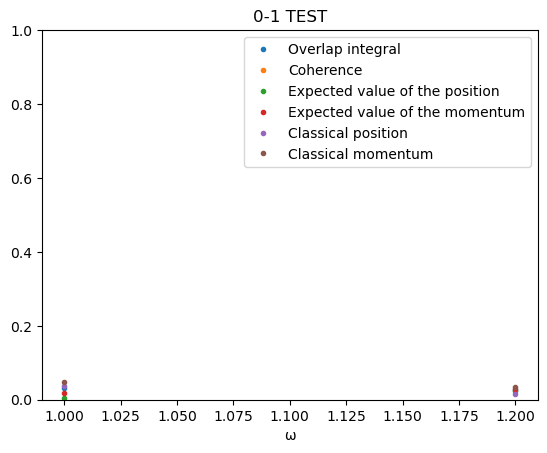

In [244]:
fig7 = plt.figure()
plt.plot(w,test_O,'.',label = 'Overlap integral')
plt.plot(w,test_coh,'.',label = 'Coherence')
plt.plot(w,test_xq,'.',label = 'Expected value of the position')
plt.plot(w,test_pq,'.',label = 'Expected value of the momentum')
plt.plot(w,test_x,'.',label = 'Classical position')
plt.plot(w,test_p,'.',label = 'Classical momentum')
plt.ylim([0,1])
plt.title('0-1 TEST')
plt.xlabel('ω')
plt.legend()
plt.show()

Save data and figures

In [226]:
fig1.savefig('Quantum_potential (N = '+str(N)+' phonons).png')

In [227]:
fig2.savefig('Overlap (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).png')

In [228]:
fig3.savefig('Coherence (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).png')

In [229]:
fig4.savefig('Frequency spectrum (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).png')

In [230]:
fig5.savefig('Standard deviation (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).png')

In [231]:
fig6.savefig('Classical_vs_quantum (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).png')

C:\Users\rodri\AppData\Local\Temp\ipykernel_18056\2191526474.py:1: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig6.savefig('Classical_vs_quantum (ω = '+str(format(w[rep],'.1f'))+' s⁻¹).png')


In [232]:
fig7.savefig('01test')

Notas y checks

In [233]:
'''
# EXAMEN PARA COMPROBAR QUE EL TEST 0-1 FUNCIONA #

cha = np.zeros([1000,25])
cha[0] = 0.5
coef = np.linspace(3.5,3.7,25)
for m in range(25):
    for n in range(1,1000):
        cha[n,m] = coef[m]*cha[n-1,m]*(1-cha[n-1,m])

r = np.zeros(25)
for i in tqdm(range(25)):
    r[i] = chaos_test(cha[:,i])

plt.plot(coef,r,'.')
plt.ylim([0,1])
'''

"\n# EXAMEN PARA COMPROBAR QUE EL TEST 0-1 FUNCIONA #\n\ncha = np.zeros([1000,25])\ncha[0] = 0.5\ncoef = np.linspace(3.5,3.7,25)\nfor m in range(25):\n    for n in range(1,1000):\n        cha[n,m] = coef[m]*cha[n-1,m]*(1-cha[n-1,m])\n\nr = np.zeros(25)\nfor i in tqdm(range(25)):\n    r[i] = chaos_test(cha[:,i])\n\nplt.plot(coef,r,'.')\nplt.ylim([0,1])\n"

Consejo: para que sea más fiable usar pasos de tiempo relativamente grandes y priorizar simulaciones a tiempos largos (> 2500 s con dt = 0.5) con varios valores de c